<a href="https://colab.research.google.com/github/yezawei/micrograd/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Micrograd: Introduction

Micrograd - autograd engine (automatic gradient) allows to efficiently evaluate the gradient of loss function with respect to the weight of neural network. This way we can interatively tune the weight of the neural network to minimize the loss function and therefore improve the accuracy of the network.
It is a scalar valued autograd engine:it is working on level of individual scalars.

Backpropagation would be at he mathematical core of any modern deep neural network library(pytorch/jaxx).

# Usage Exmaple to Intro: what can we do?


Install micrograd


In [ ]:
pip install micrograd

Exmaple below is from Andrej Karpathy's youtube video "The spelled-out intro to neural networks and backpropagation: building micrograd"

In [ ]:
from micrograd.engine import Value

Mathimatical expression (that makes no sense 😑):

In [ ]:
a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

24.7041
138.8338
645.5773


**Micrograd** will build in background this entire mathematical expression from building values from a to g.

*.backward* initialises **backpropagadation**:


*   it will go backwards through that expression graph
*   It will recursively apply the chain rule from calculus
*   Will provide us with evaluation of derivative of g with respect to all internal nodes, as well as with respect to the inputs(a, b).





So it tells us that the slope of growth of a is ≈ 138, and the slope of growth of b is  ≈  645.5

# Getting hands on some basic knowledge

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

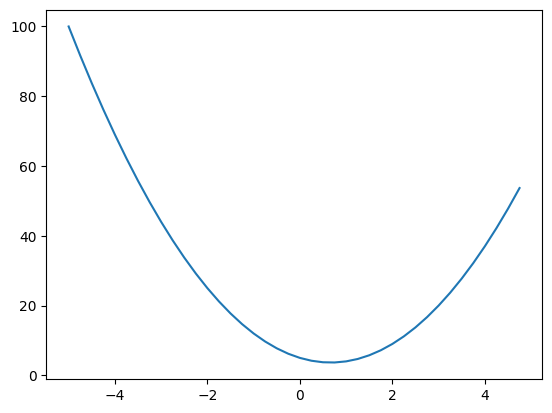

In [ ]:
xs = np.arange(-5, 5, 0.25) #create a set of scale values to fit in with arange from negative 5 to 5 with steps of 0.25
ys = f(xs) #applying function on any of these elements we created in xs independently
ys
plt.plot(xs, ys) #ploting the data



The **derivative** of a function $f(x)$ is defined as:

$f(x) = \underset{{h} \to 0}\lim\dfrac{f(x + h) - f(x)}{h}$


In [ ]:
h = 0.001 #do not use to many zeros, as it is using float number arithmetic and representation of these numbers in computer memory is finite
x = 3.0
(f(x+h) - f(x))/h

14.00300000000243

In [ ]:
#doing more complex stuff
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.000001

#inputs
a = 2.0
b = -3.0
c = 10.0

#expressions
d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.9999969999999996
slope -3.000000000419334


#Core Value object of micrograd and its visualisation

In [ ]:
class Value:

  def __init__(self, data):
    self.data = data

#repr provides us with a way to print out data in a nice and clear way in python
  def __repr__(self):
    return f"Value(data={self.data})"

In [ ]:
a = Value(2.0)
a

Value(data=2.0)

It doesn't know yet, how to add two value objects so if we try to add, we will get the following:





In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = a + b

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [ ]:
class Value:

  def __init__(self, data):
    self.data = data

#repr provides us with a way to print out data in a nice and clear way in python
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    out = Value(self.data + other.data)
    return out

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = a + b
c

Value(data=-1.0)

Now let's add some other math to it:

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''): #children keeps track of values we use for other values   #op keeps track of what operations we used
    self.data = data
    self.grad = 0.0 #at initializing we assume that gradient is 0
    self._backward = lambda: None #empty function ie for leafe node
    self._prev = set(_children) #initially both children and _.prev set are empty
    self._op = _op
    self.label = label

#repr provides us with a way to print out data in a nice and clear way in python
  def __repr__(self):
    return f"Value(data={self.data})"

#adding:
  def __add__(self,other):
    out = Value(self.data + other.data, (self, other), '+') # (self, other) - children

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0* out.grad


    out._backward = _backward
    return out

#multiplication
  def __mul__(self,other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward
    return out

#tanh
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value (10.0, label='c')
d = a*b + c
d

Value(data=4.0)

In [ ]:
d._prev #example of how children stores value

{Value(data=-6.0), Value(data=10.0)}

In [ ]:
d._op #example of how op returns operation used

'+'

Visualisation with graphviz

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

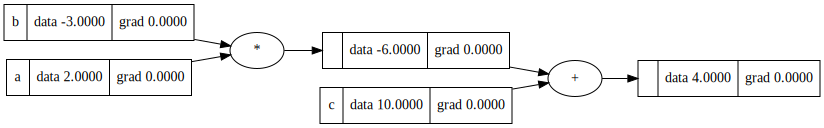

In [ ]:
draw_dot(d)

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value (10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

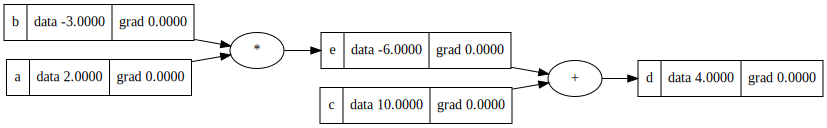

In [ ]:
draw_dot(d)

In [ ]:
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

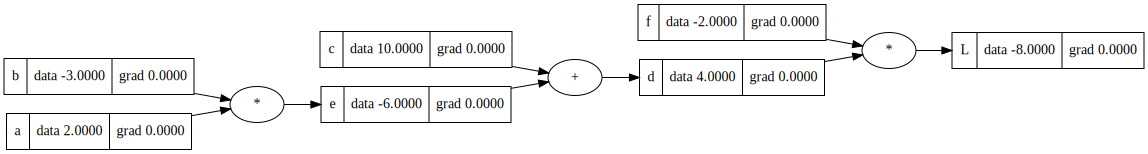

In [ ]:
draw_dot(L)

#  Manual Backpropagadation

In [ ]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

-3.9999999999995595


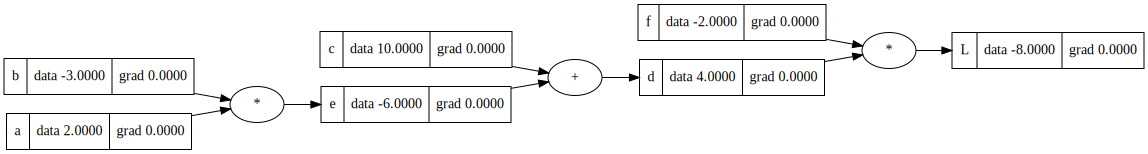

In [ ]:
draw_dot(L)

**Chain Rule:**

The chain rule may also be expressed in Leibniz's notation. If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well, via the intermediate variable y.


\begin{align}
  \frac{dz}{dx} = \frac{dz}{dy} * \frac{dy}{dx}
    \end{align}

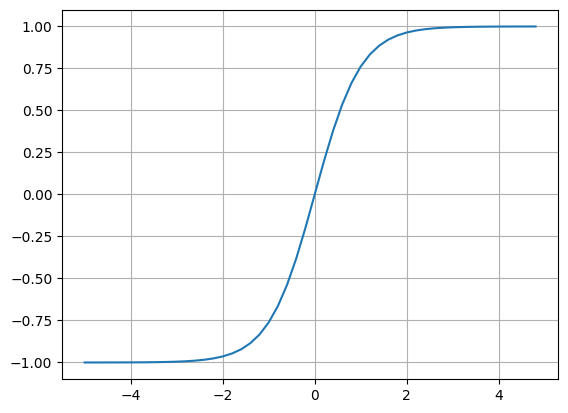

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

# Manual Backpropagadation: Neuron

Is math neuron that much different from biolofy neuron?

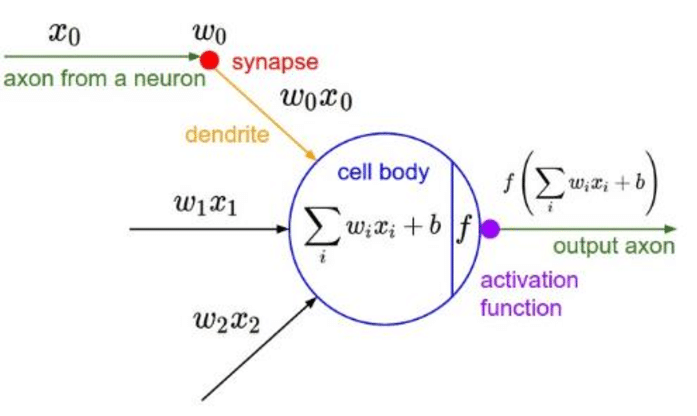

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n' #aka cell body if referencing to the picture above

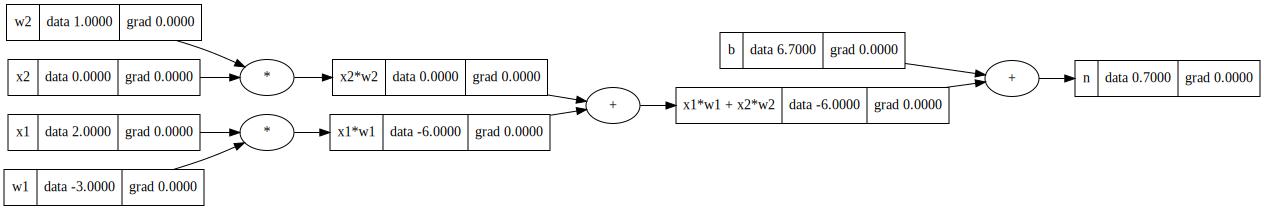

In [ ]:
draw_dot(n)

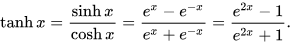

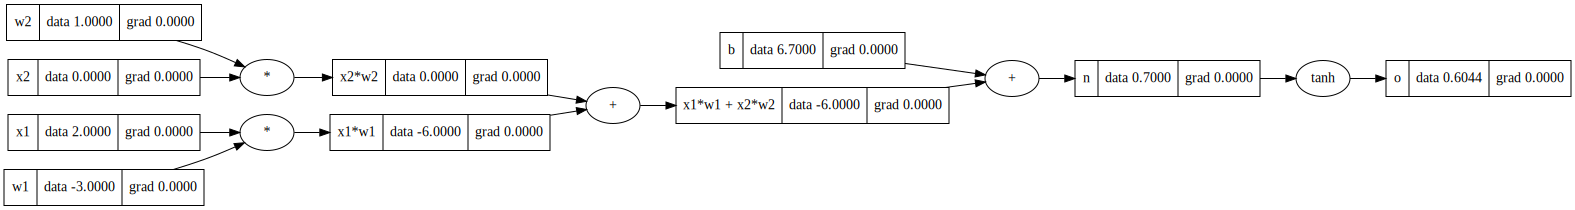

In [ ]:
o = n.tanh(); o.label = 'o'
draw_dot(o)

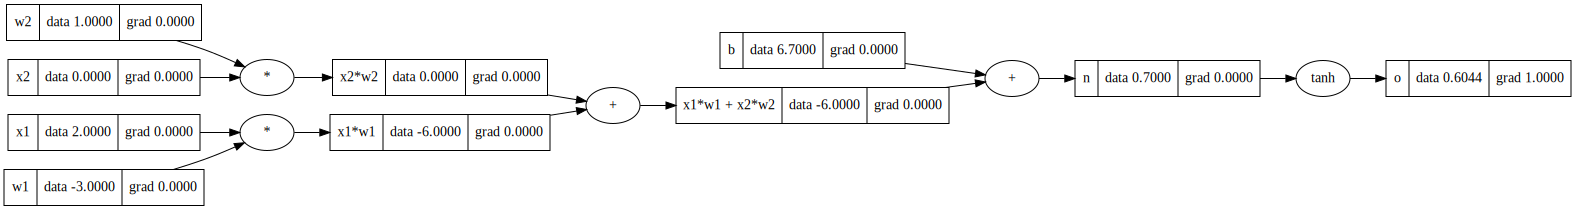

In [ ]:
o.grad = 1.0
draw_dot(o)

In [ ]:
1 - o.data**2 #local deriviative of tanh

0.6347395899824584

In [ ]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 aka do/dn = 1 - o**2

In [ ]:
n.grad = 0.6347395899824584

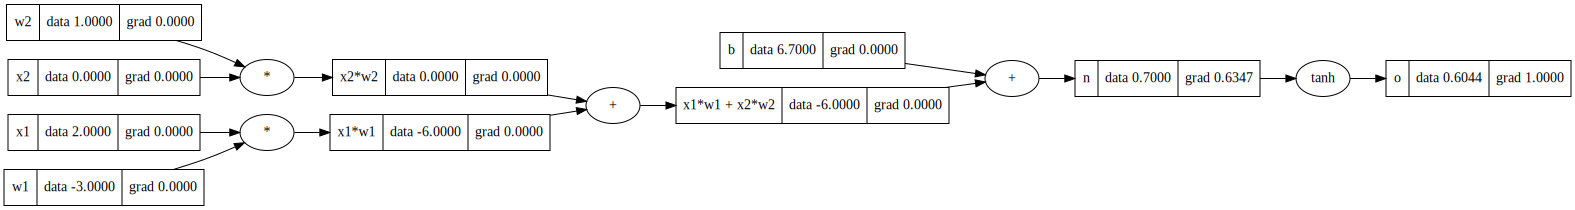

In [ ]:
draw_dot(o)

In [ ]:
x1w1x2w2.grad = 0.6347395899824584 #if will be the same as n for each of the compronents as it is plus operation
b.grad = 0.6347395899824584


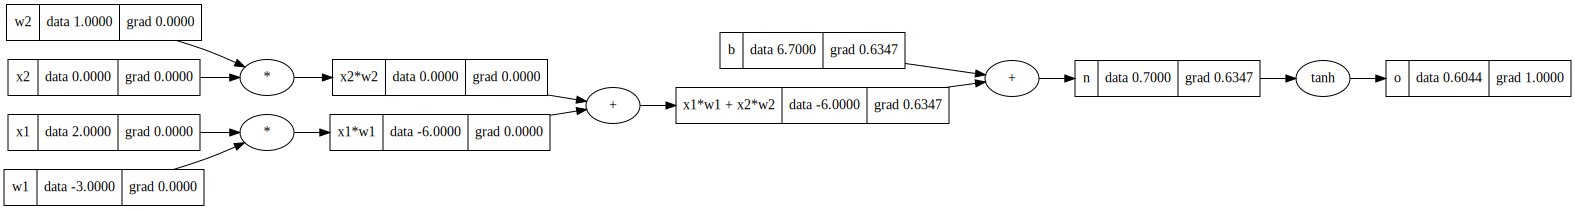

In [ ]:
draw_dot(o)

In [ ]:
x2w2.grad = 0.6347395899824584
x1w1.grad = 0.6347395899824584

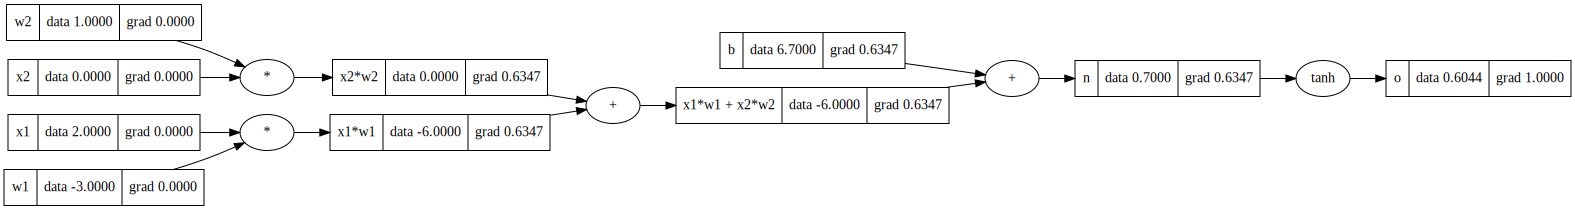

In [ ]:
draw_dot(o)

In [ ]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

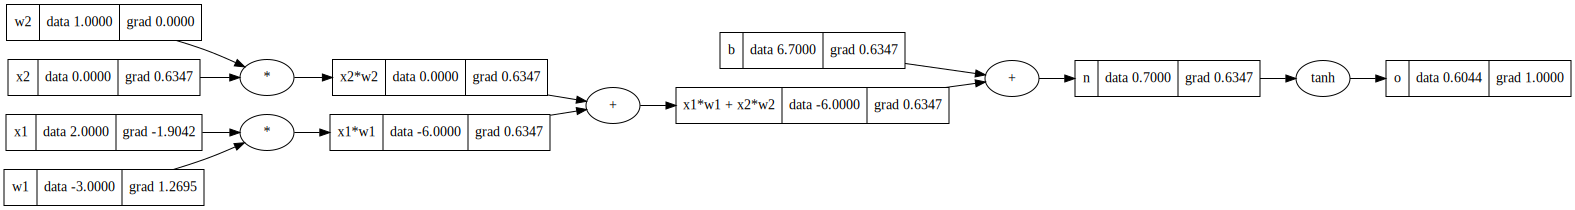

In [ ]:
draw_dot(o)

# Implementing the backward function for each operation

add what we were doing in euron to Value class for automation